In [34]:
# ! pip install --upgrade pip
# ! pip install --upgrade numpy scipy matplotlib pyhf cabinetry uproot pandas

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import cabinetry
import pyhf
import json
from pathlib import Path

cabinetry.__version__

'0.5.2'

# Building the model

`Cabinetry` has the nice feature that it can crate `pyhf` models from `root` files. 

First we need to chose our fitting variable and the binning. Here we chose to fit in 50 bins of $\Delta E$.

In [50]:
bins = np.linspace(-0.4, 0.4, 50 + 1)

We define `cabinetry` models vie a `config` dictionary, containing different settings:

First, we give our measurement a name, denife a parameter of interest (POI), and input path containing the `root` files and a histogram folder, where cabinetry automatically saves the historgam yields.

In [51]:
cabinetry.set_logging()

BASE = Path('/home/belle/zhangboy/Summer_workshop_2023')

config = {
   "General":{
      "Measurement": "B2Kpi0",
      "POI": "Signal_norm",
      "InputPath": str(BASE / "{SamplePath}"), # wildcard for samples
      "HistogramFolder": "histograms/"

   }
}

Int the `Regions` setting, we tell `cabinetry` which variable in the `root` files it should load and define our signal region via the cut $| \Delta E | < 0.4 GeV$. It is a list, because we can use events from more than one phase space region. Additionally, we define the binning.

Next we can define our `Samples` again in a list, where we specify the name of each sample, the `root` file in the `InputPath`, the `Tree` and whether it is data or not. We can also pass a list of files as `SamplePath` and `cabinetry` will combine the files for us. 

In [52]:
config.update({
   "Regions":[
      {
         "Name": "signal_region",
         "Variable": "B_deltaE",             # which variable we bin histograms in
         "Filter": "abs(B_deltaE) < 0.4",           # event selection 
         "Binning": list(bins)
      }
   ]
})

config.update({
   "Samples":[
      {
         "Name": "Data",
         "SamplePath": ["sig_test.root",'qqbar_test.root'],
         "Tree": "B",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "SamplePath": "sig_template.root",
         "Tree": "B",
      },
      {
         "Name": "qqbar",
         "SamplePath": "qqbar_template.root",
         "Tree": "B",
      }
   ]
})

Lastly, we can add some modifiers: 

First, we add some normalisation factors for the signal and background. Here, we specify our `POI`, `Signal_norm`.

Then we can add some other systematics.


In [53]:
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10]
      },
        {
         "Name": "qqbar_norm",
         "Samples": "qqbar",    # we want this parameter to scale the misID
         "Nominal": 1,
         "Bounds": [-5, 10]
      }
   ]
})

config.update({
   "Systematics":[
   ],
})

`cabinetry` lets us validate our `config`,


In [57]:
cabinetry.configuration.validate(config)

True

Additionally, we can print an overview. We see that we have _ samples, _ regions, _ normalisation factors and _ systematics.

In [58]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   2 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


## Creating the histograms

Given that our validation succeeds, we can `build` the histrograms for our model. This will create the hisrograms from the `root` files and save them into the `HistogramFolder`.

In [60]:
cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz


You can also provide existing histograms you built yourself for `cabinetry` to use, see the [cabinetry-tutorials](https://github.com/cabinetry/cabinetry-tutorials) repository for an example.

We can now visualise what we produced:

INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit_log.pdf


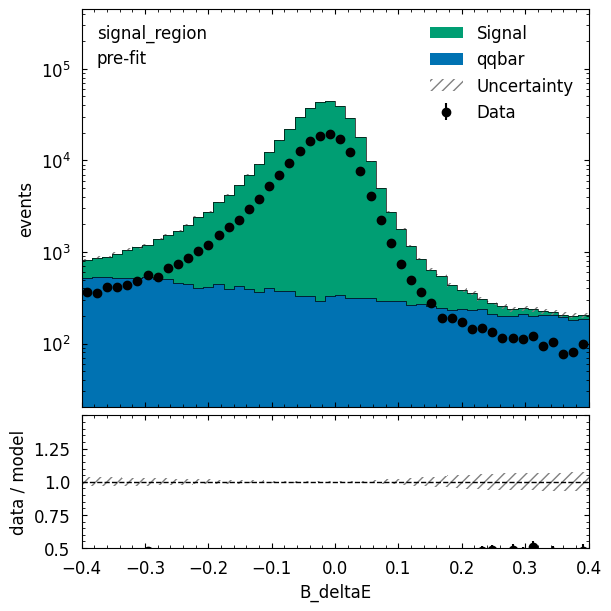

In [61]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

`cabinetry` will automatically save this image in a `/figures` folder.

# Building a `pyhf` workspace

We now construct a `pyhf` workspace, which contains everything to build our likelihood function. This can also be used as an input file for `pyhf`. 

In [62]:
workspace_path = "b2kpi_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region signal_region
DEBUG - cabinetry.workspace - adding NormFactor qqbar_norm to sample qqbar in region signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to b2kpi_workspace.json


In [20]:
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        292.0,
                        332.0,
                        348.0,
                        437.0,
                        546.0,
                        597.0,
                        667.0,
                        880.0,
                        1030.0,
                        1227.0,
                        1518.0,
                        2008.0,
                        2305.0,
                        3023.0,
                        3808.0,
                        4928.0,
                        6618.0,
                        8760.0,
                        11852.0,
                        16259.0,
                        21738.0,
                        29317.0,
                        36927.0,
                        43132.0,
                        44387.0,
                        39049.0,
                        2878

## Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues. The `visualize.modifier_grid` function creates a figure showcasing the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (50 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


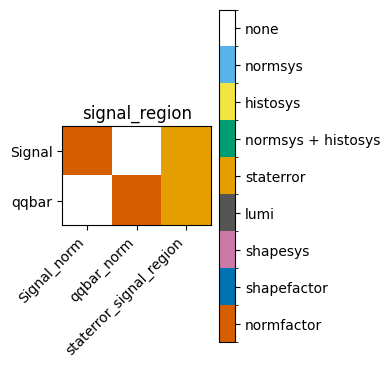

In [21]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

# Performing statistical inference

To perform inference, we need two things: a probability density function (pdf), or `model`, and data to fit it to. Both are derived from the workspace specification.

In [22]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (50 new nuisance parameters)


We see that all the modifiers that we defined for our model appear here.

## Maximum likelihood estimate (MLE)

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [23]:
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
parameters

array([0.42792591, 0.44234952, 1.0077702 , 0.98199766, 1.02045173,
       0.99474119, 0.98279808, 0.99831745, 1.02748564, 0.96384207,
       1.00391891, 1.00280681, 1.0033123 , 0.99389142, 1.00490785,
       1.01094809, 1.00878453, 0.99400277, 0.99196877, 0.9927785 ,
       0.99737881, 0.99517388, 0.99990802, 0.9988039 , 1.00341656,
       0.9987283 , 1.0011772 , 1.00429247, 0.99910527, 0.9985485 ,
       0.99429287, 1.01181018, 1.01313079, 0.9858978 , 0.99093659,
       0.99806669, 0.99739633, 0.9332756 , 1.00281024, 1.01125425,
       0.97630059, 1.02497039, 1.02934682, 1.00961528, 1.02928001,
       1.01816789, 1.04589195, 0.98675715, 1.01986363, 0.94998272,
       0.96814791, 1.02678408])

In [30]:
fit_results = cabinetry.fit.fit(model, data, init_pars=list(parameters))

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 190.1                      │             Nfcn = 3462              │
│ EDM = 4.33e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────────────────

The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results. 

In [63]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

Signal_norm: 0.428 +/- 0.001
qqbar_norm: 0.442 +/- 0.011
staterror_signal_region[0]: 1.008 +/- 0.030
staterror_signal_region[1]: 0.982 +/- 0.029
staterror_signal_region[2]: 1.020 +/- 0.028
staterror_signal_region[3]: 0.995 +/- 0.027
staterror_signal_region[4]: 0.983 +/- 0.026
staterror_signal_region[5]: 0.998 +/- 0.025
staterror_signal_region[6]: 1.027 +/- 0.024
staterror_signal_region[7]: 0.964 +/- 0.023
staterror_signal_region[8]: 1.004 +/- 0.021
staterror_signal_region[9]: 1.003 +/- 0.020
staterror_signal_region[10]: 1.003 +/- 0.019
staterror_signal_region[11]: 0.994 +/- 0.017
staterror_signal_region[12]: 1.005 +/- 0.016
staterror_signal_region[13]: 1.011 +/- 0.014
staterror_signal_region[14]: 1.009 +/- 0.013
staterror_signal_region[15]: 0.994 +/- 0.011
staterror_signal_region[16]: 0.992 +/- 0.010
staterror_signal_region[17]: 0.993 +/- 0.009
staterror_signal_region[18]: 0.997 +/- 0.008
staterror_signal_region[19]: 0.995 +/- 0.007
staterror_signal_region[20]: 1.000 +/- 0.006
staterro

It is helpful to visualize the fit results. Let's start with the pull plot showing us best-fit parameter results.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


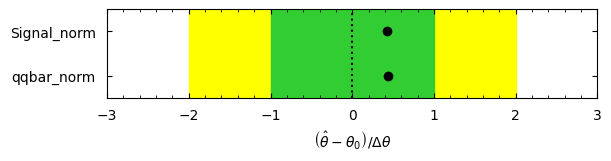

In [64]:
cabinetry.visualize.pulls(fit_results)

The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


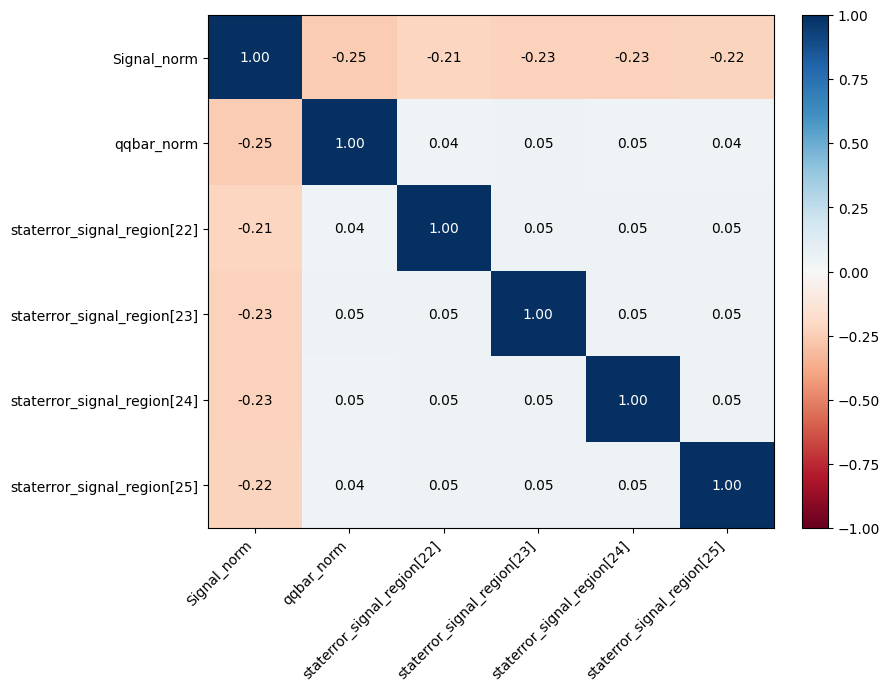

In [67]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)

Let us look at the post-fit result. This is as easy as passing `fit_results` to `cabinetry.model_utils.prediction`.

DEBUG - cabinetry.model_utils - total stdev is [[11.1, 11.4, 11.5, 11.9, 12.4, 12.7, ..., 5.82, 5.73, 5.64, 5.51, 5.41, 5.42]]
DEBUG - cabinetry.model_utils - total stdev per channel is [396]


INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_postfit_log.pdf


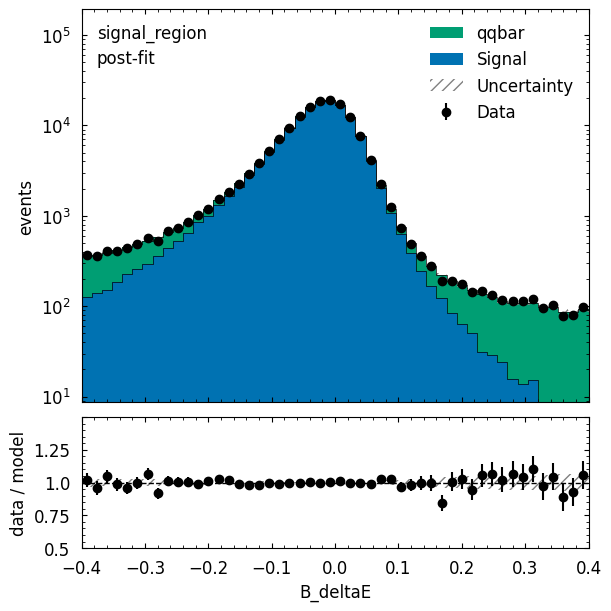

In [35]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)



Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default). The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.



In [68]:
model_pred = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒══════════╤═════════════════╤════════════════╤════════════════╤════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│ sample   │ s

# More advanced features

In [36]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 183.8                      │             Nfcn = 3404              │
│ EDM = 5.51e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 183.799919 at 

In [37]:
asimov_data

[814.0,
 868.0,
 879.0,
 962.0,
 1062.0,
 1122.0,
 1195.0,
 1385.0,
 1531.0,
 1684.0,
 1968.0,
 2412.0,
 2722.0,
 3472.0,
 4200.0,
 5355.0,
 7009.0,
 9124.0,
 12259.0,
 16638.0,
 22117.0,
 29645.0,
 37261.0,
 43427.0,
 44718.0,
 39392.0,
 29093.0,
 17965.0,
 9820.0,
 4989.0,
 2761.0,
 1789.0,
 1169.0,
 840.0,
 642.0,
 551.0,
 432.0,
 384.0,
 354.0,
 307.0,
 278.0,
 256.0,
 238.0,
 242.0,
 236.0,
 225.0,
 219.0,
 207.0,
 202.0,
 204.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [38]:
import copy
smoothing_config = copy.deepcopy(config)
smoothing_config["General"]["HistogramFolder"] = "histograms_smoothing/"
smoothing_config.update({
   "Systematics":[
      {
         "Name":"Modeling",
         "Up": {"SamplePath": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Smoothing": {"Algorithm": "353QH, twice"},  # smoothing applied
         "Type": "NormPlusShape"
      }
   ]
})
cabinetry.templates.build(smoothing_config, method="uproot")
cabinetry.templates.postprocess(smoothing_config)
_ = cabinetry.visualize.templates(smoothing_config)

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_qqbar.npz
DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.h

In [42]:
scan_results = cabinetry.fit.scan(model, data, "Signal_norm", n_steps=10, init_pars=list(parameters))

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 190.1                      │             Nfcn = 3462              │
│ EDM = 4.33e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 190.125816 at 

INFO - cabinetry.visualize.utils - saving figure as figures/scan_Signal_norm.pdf


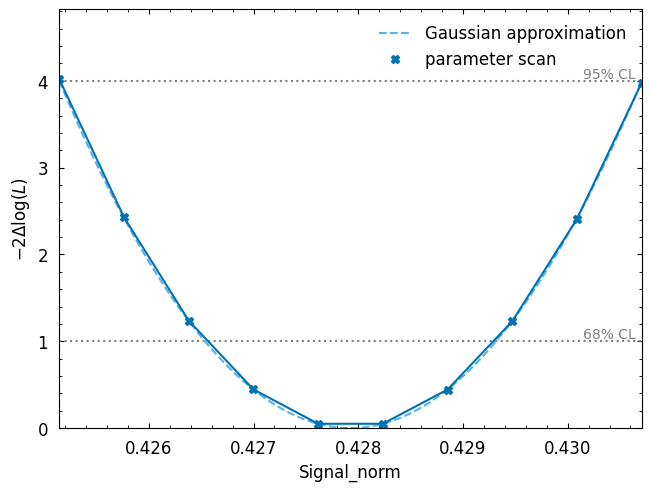

In [43]:
cabinetry.visualize.scan(scan_results)

In [45]:
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, init_pars=list(parameters))

INFO - cabinetry.fit - calculating impact of qqbar_norm on Signal_norm
DEBUG - cabinetry.fit - impact of qqbar_norm is zero, skipping fit
DEBUG - cabinetry.fit - impact of qqbar_norm is zero, skipping fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 191.1                      │             Nfcn = 3461              │
│ EDM = 8.58e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼─────────────────────────────────────

INFO - cabinetry.visualize.utils - saving figure as figures/ranking.pdf


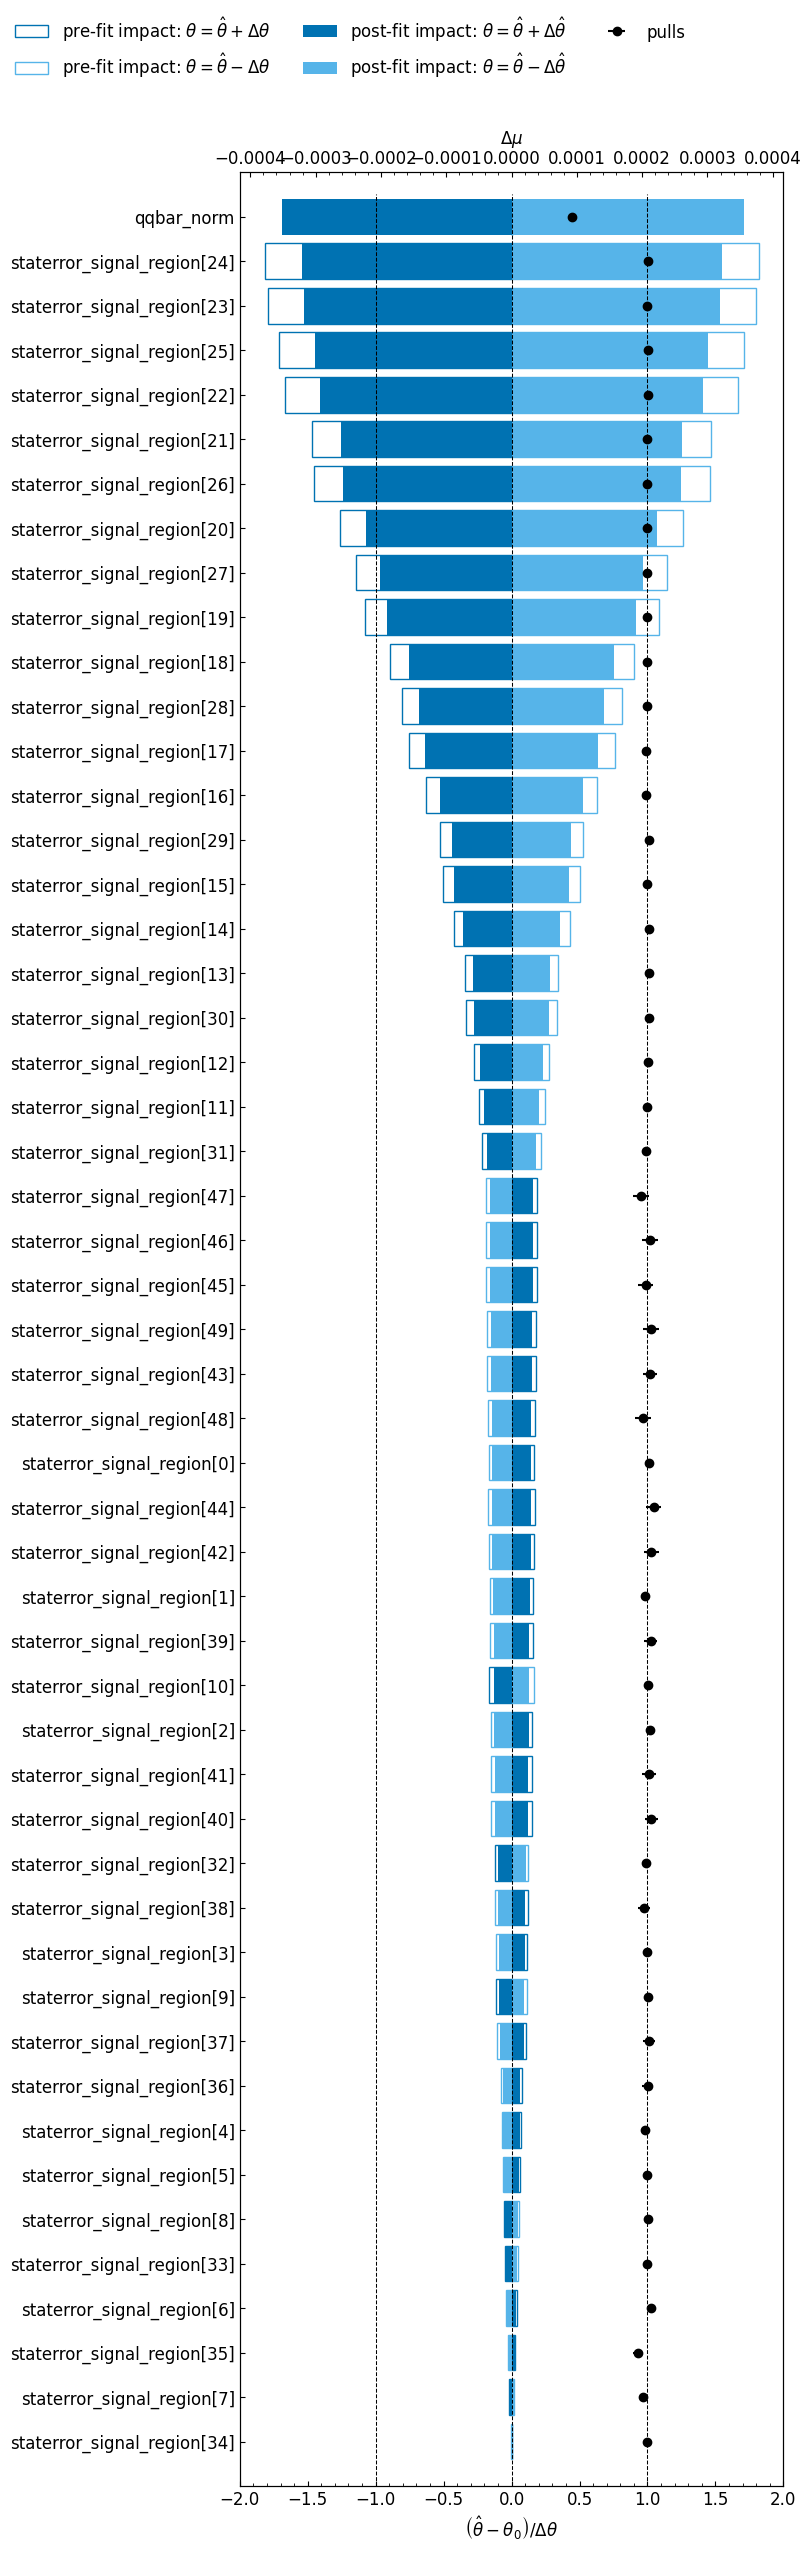

In [46]:
cabinetry.visualize.ranking(ranking_results)

In [31]:
asimov_data = cabinetry.model_utils.asimov_data(model)
